In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import xgboost as xgb
import shap
import matplotlib.pyplot as plt
from lime import lime_tabular

In [3]:
# ========================================
# 1. 데이터 경로 및 파일 불러오기
# ========================================
# 'XAI_Data' 폴더에서 데이터 파일 불러오기
data_folder = 'XAI_Data/'

# 'Unnamed: 0' 열을 제거하는 함수 정의
def drop_unnamed(df):
    unnamed_cols = [col for col in df.columns if "Unnamed" in col]
    if unnamed_cols:
        df = df.drop(columns=unnamed_cols)
    return df

# 훈련 데이터, 테스트 데이터, 제출 양식 파일 읽어오기
# NA로 표시된 문자열은 결측치로 처리합니다.
train_df = pd.read_csv(f'{data_folder}cs-training.csv', na_values=['NA'], index_col=0)
test_df  = pd.read_csv(f'{data_folder}cs-test.csv', na_values=['NA'], index_col=0)
sample_submission = pd.read_csv(f'{data_folder}sampleEntry.csv', index_col=0)

# 'Unnamed: 0' 열 제거
train_df = drop_unnamed(train_df)
test_df = drop_unnamed(test_df)
sample_submission = drop_unnamed(sample_submission)

print(f"Train Data Shape: {train_df.shape}")
print(f"Test Data Shape: {test_df.shape}")

# 훈련 데이터 상위 5개 행 출력
print("\n[Train Data Head]")
print(train_df.head())

Train Data Shape: (150000, 11)
Test Data Shape: (101503, 11)

[Train Data Head]
   SeriousDlqin2yrs  RevolvingUtilizationOfUnsecuredLines  age  \
1                 1                              0.766127   45   
2                 0                              0.957151   40   
3                 0                              0.658180   38   
4                 0                              0.233810   30   
5                 0                              0.907239   49   

   NumberOfTime30-59DaysPastDueNotWorse  DebtRatio  MonthlyIncome  \
1                                     2   0.802982         9120.0   
2                                     0   0.121876         2600.0   
3                                     1   0.085113         3042.0   
4                                     0   0.036050         3300.0   
5                                     1   0.024926        63588.0   

   NumberOfOpenCreditLinesAndLoans  NumberOfTimes90DaysLate  \
1                               13           

In [4]:
# ========================================
# 2. 데이터 전처리 및 변수 설명
# ========================================
# 타깃 변수 : 'SeriousDlqin2yrs' (1: 연체 있음, 0: 연체 없음)
target_col = 'SeriousDlqin2yrs'

# 훈련 데이터에 불필요한 'Id' 칼럼이 있다면 제거 (테스트 데이터에서는 추후 보존)
if 'Id' in train_df.columns:
    train_df.drop('Id', axis=1, inplace=True)

# 결측치가 있는 행을 간단하게 제거 (실제 상황에서는 대체 방법 고려)
train_df.dropna(subset=[
    'SeriousDlqin2yrs',
    'RevolvingUtilizationOfUnsecuredLines',
    'age',
    'NumberOfTime30-59DaysPastDueNotWorse',
    'DebtRatio',
    'MonthlyIncome',
    'NumberOfOpenCreditLinesAndLoans',
    'NumberOfTimes90DaysLate',
    'NumberRealEstateLoansOrLines',
    'NumberOfTime60-89DaysPastDueNotWorse',
    'NumberOfDependents'
], inplace=True)

# 훈련 데이터에서 피처(X)와 타깃(y) 분리
X = train_df.drop(columns=[target_col])
y = train_df[target_col]

# 테스트 데이터 처리
# 테스트 데이터에 'Id' 칼럼이 있다면 보존 후 제거하여 예측에 사용
if 'Id' in test_df.columns:
    test_id = test_df['Id']
    test_df.drop('Id', axis=1, inplace=True)
else:
    test_id = pd.Series(range(1, len(test_df) + 1), name='Id')

# 혹시 테스트 데이터에 결측치가 있다면 숫자형 변수의 중앙값으로 대체
test_df.fillna(test_df.median(numeric_only=True), inplace=True)

# **중요:** 모델이 학습한 피처 순서 및 개수(X.columns)와 동일하게 맞춰줍니다.
# 만약 테스트 데이터에 훈련에 사용되지 않은 추가 컬럼이 있으면 해당 컬럼을 제거합니다.
test_df = test_df[X.columns]


In [5]:
# ========================================
# 3. 학습/검증 데이터셋 분할
# ========================================
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)
print(f"X_train shape: {X_train.shape}, X_val shape: {X_val.shape}")

X_train shape: (84188, 10), X_val shape: (36081, 10)


In [6]:
# ========================================
# 4. XGBoost 모델 학습
# ========================================
model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=4,
    learning_rate=0.1,
    random_state=42,
    use_label_encoder=False,
    eval_metric='auc'
)

model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    early_stopping_rounds=10,
    verbose=False
)

`early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=4, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=42,
              reg_alpha=0, reg_lambda=1, ...)

In [7]:
# ========================================
# 5. 모델 평가 (Validation)
# ========================================
val_pred_prob = model.predict_proba(X_val)[:, 1]
val_auc = roc_auc_score(y_val, val_pred_prob)
print(f"Validation AUC: {val_auc:.4f}") 

Validation AUC: 0.8535


 99%|===================| 35895/36081 [00:45<00:00]        

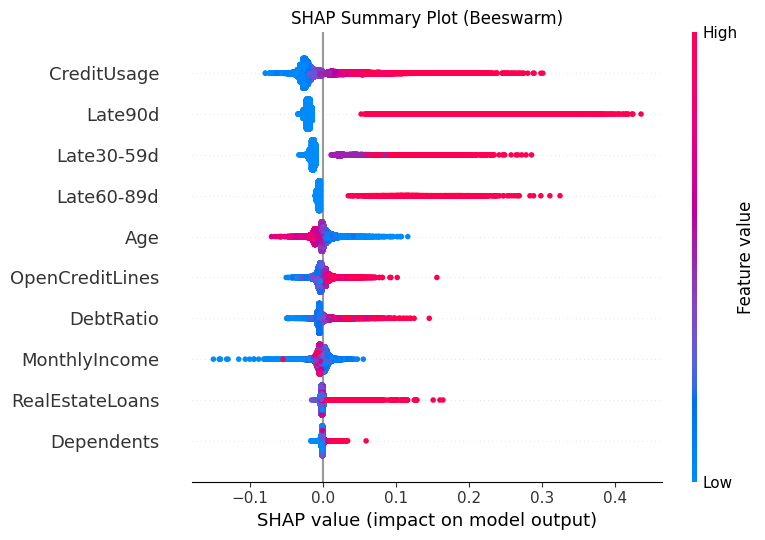

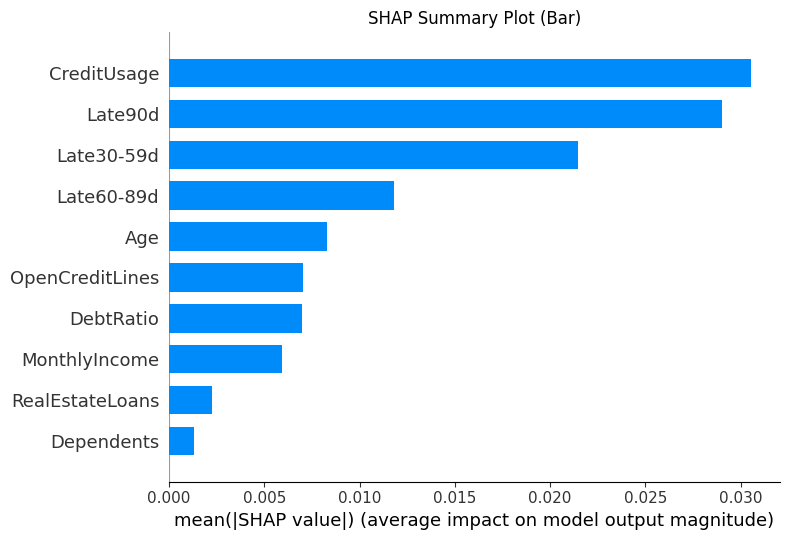

In [8]:
# ========================================
# 6.  SHAP 해석
# ========================================

# 1. SHAP Explainer 생성 (확률로 출력)
explainer = shap.Explainer(model, X_train, model_output="probability")
shap_values = explainer(X_val)

# 이진 분류이므로 클래스 1에 해당하는 SHAP 값을 사용
if isinstance(shap_values.values, list):
    shap_values_filtered = shap_values.values[1]
else:
    shap_values_filtered = shap_values.values

# 피처 이름 매핑
feature_rename_map = {
    'RevolvingUtilizationOfUnsecuredLines': 'CreditUsage',
    'age': 'Age',
    'NumberOfTime30-59DaysPastDueNotWorse': 'Late30-59d',
    'DebtRatio': 'DebtRatio',
    'MonthlyIncome': 'MonthlyIncome',
    'NumberOfOpenCreditLinesAndLoans': 'OpenCreditLines',
    'NumberOfTimes90DaysLate': 'Late90d',
    'NumberRealEstateLoansOrLines': 'RealEstateLoans',
    'NumberOfTime60-89DaysPastDueNotWorse': 'Late60-89d',
    'NumberOfDependents': 'Dependents'
}

X_val_renamed = X_val.rename(columns=feature_rename_map)
X_val_filtered = X_val_renamed.copy()
shap_values_filtered = shap_values_filtered.copy()
if shap_values_filtered.ndim == 1:
    shap_values_filtered = shap_values_filtered.reshape(1, -1)

# 2. 글로벌 SHAP 시각화
shap.summary_plot(shap_values_filtered, X_val_filtered, show=False)
plt.title("SHAP Summary Plot (Beeswarm)")
plt.tight_layout()
plt.show()

shap.summary_plot(shap_values_filtered, X_val_filtered, plot_type="bar", show=False)
plt.title("SHAP Summary Plot (Bar)")
plt.tight_layout()
plt.show()



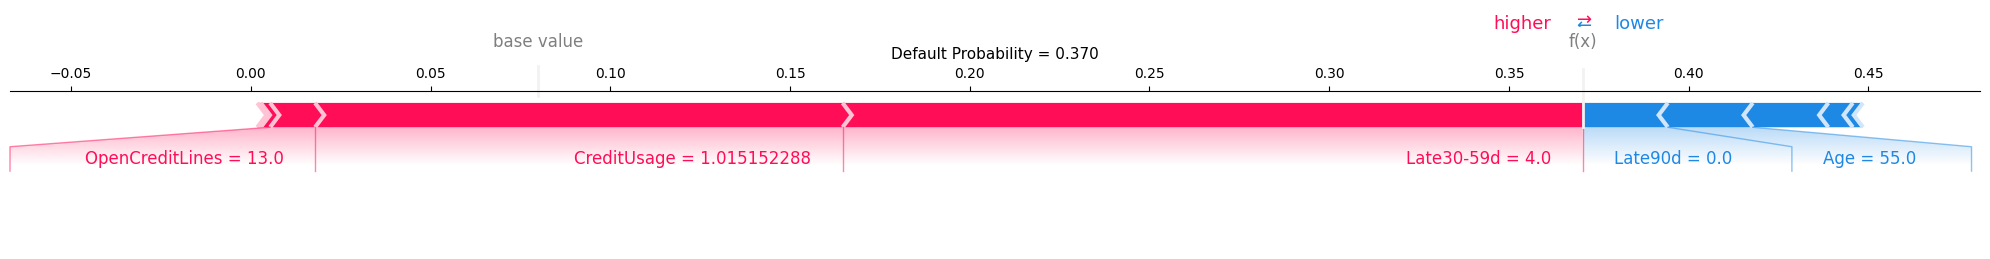

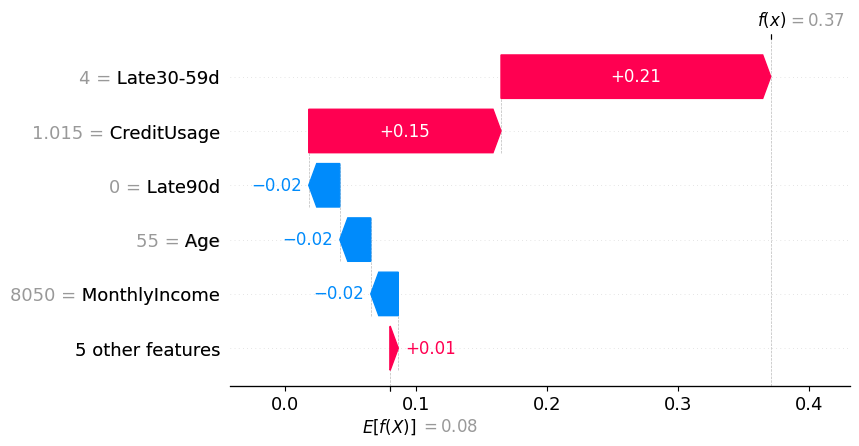

In [9]:
# 3. 로컬 SHAP Force Plot
idx = 16
if idx >= X_val_filtered.shape[0]:
    raise IndexError(f"idx {idx} is out of range (0 ~ {X_val_filtered.shape[0]-1})")

sample = X_val_filtered.iloc[idx]
shap_value_sample = shap_values_filtered[idx]
base_value = explainer.expected_value

fig = shap.plots.force(
    base_value, 
    shap_value_sample, 
    sample,
    matplotlib=True, 
    show=False
)


# "f(x) = 숫자" 형태인 텍스트에서 숫자 부분만 제거하고, "f(x) =" 만 남기기
for text_obj in fig.axes[0].texts:
    txt = text_obj.get_text()
    if "f(x) =" in txt:
        text_obj.set_text("f(x)")

# 최종 확률(Default Probability) 계산
f_x = base_value + shap_value_sample.sum()
display_str = f"{f_x:.2f}"

# 현재 Axes의 텍스트 중에서 'display_str'과 매칭되는 것 숨기기
ax = plt.gca()
for textobj in ax.texts:
    if textobj.get_text().startswith(display_str):  
        textobj.set_visible(False)

# 제목은 Default Probability만 표시
plt.title(f"Default Probability = {f_x:.3f}", fontsize=11)
plt.tight_layout()
plt.show()

shap_explanation_single = shap.Explanation(
    values=shap_value_sample,
    base_values=base_value,
    data=sample,
    feature_names=sample.index
)

shap.plots.waterfall(shap_explanation_single, max_display=6)


In [10]:
# ========================================
# 7. LIME 해석
# ========================================
renamed_feature_names = [feature_rename_map.get(col, col) for col in X_train.columns]

lime_explainer = lime_tabular.LimeTabularExplainer(
    training_data=np.array(X_train),
    feature_names=renamed_feature_names,  # 직관적인 변수명 적용
    class_names=['No Default', 'Default'],
    mode='classification',
    discretize_continuous=True
)

# 검증 데이터셋의 한 샘플(예: 인덱스 16번째)에 대해 LIME 설명 생성
lime_idx = 16
if lime_idx >= X_val.shape[0]:
    raise IndexError(f"lime_idx {lime_idx}는 유효한 범위를 벗어났습니다. (0부터 {X_val.shape[0]-1}까지)")

instance = X_val.iloc[lime_idx].values  # 모델 예측에는 원래 데이터 사용
lime_exp = lime_explainer.explain_instance(instance, 
                                           model.predict_proba, 
                                           num_features=10)

# LIME 결과를 노트북에 시각화 (HTML 형식)
lime_exp.show_in_notebook(show_table=True, show_all=False)
# 또는 HTML 파일로 저장
lime_exp.save_to_file(f'{data_folder}lime_explanation.html')
print(f"\nLIME 설명 결과를 '{data_folder}lime_explanation.html' 파일로 저장했습니다.")


LIME 설명 결과를 'XAI_Data/lime_explanation.html' 파일로 저장했습니다.


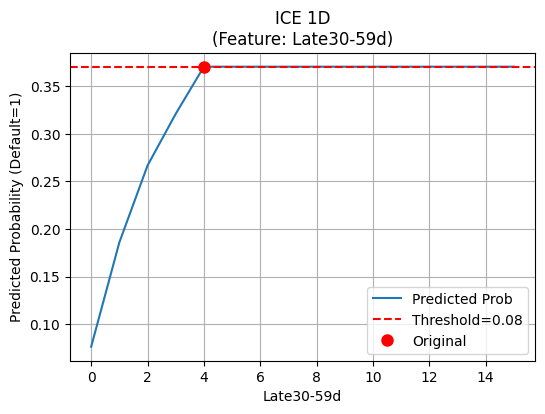

In [ ]:
# ========================================
# 8. ICE 1D
# ========================================
import numpy as np

# (1) 특정 샘플 선택
cf_idx = 16
if cf_idx >= X_val.shape[0]:
    raise IndexError(f"cf_idx {cf_idx} is out of range.")

instance_orig = X_val.iloc[cf_idx].copy()  # 원본 샘플 (원본 컬럼명)

# (2) 어떤 피처를 1D로 변화시킬지 선택
feature_cf_1d = 'NumberOfTime30-59DaysPastDueNotWorse'  # 원본 컬럼명
feature_cf_1d_renamed = feature_rename_map.get(feature_cf_1d, feature_cf_1d)

# (3) 변화 범위 설정 (최소 ~ 최대)
# feat_min = int(X_val[feature_cf_1d].min())
# feat_max = int(X_val[feature_cf_1d].max())

# (3) 변화 범위 임의로 설정 
feat_min = 0
feat_max =15

# 정수 범위 균등 분할
grid_points = np.arange(feat_min, feat_max + 1, 1)

pred_probs = []
for val in grid_points:
    # 임시로 이 샘플의 해당 피처만 바꾸고 예측
    temp_instance = instance_orig.copy()
    temp_instance[feature_cf_1d] = val

    # 모델 예측 확률 (클래스1=연체) 계산
    prob = model.predict_proba(temp_instance.values.reshape(1, -1))[0, 1]
    pred_probs.append(prob)

# (4) 플롯
plt.figure(figsize=(6,4))
plt.plot(grid_points, pred_probs, label='Predicted Prob')
plt.axhline(0.08, color='r', linestyle='--', label='Threshold=0.08')

# 원본 샘플의 위치와 확률
orig_val = instance_orig[feature_cf_1d]
orig_prob = model.predict_proba(instance_orig.values.reshape(1, -1))[0, 1]
plt.plot(orig_val, orig_prob, 'ro', markersize=8, label='Original')

plt.title(f"ICE 1D\n(Feature: {feature_cf_1d_renamed})")
plt.xlabel(f"{feature_cf_1d_renamed}")
plt.ylabel("Predicted Probability (Default=1)")
plt.legend()
plt.grid(True)
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


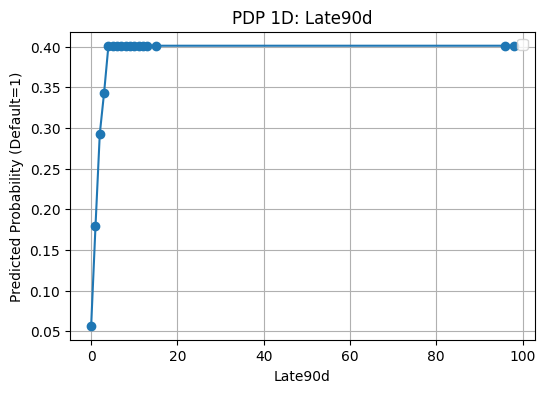

In [ ]:
# ========================================
# 9. PDP 1D
# ========================================
from sklearn.inspection import partial_dependence, PartialDependenceDisplay

feat_pdp_1d = 'NumberOfTime30-59DaysPastDueNotWorse'  # 원본 이름
feat_pdp_1d_renamed = feature_rename_map.get(feat_pdp_1d, feat_pdp_1d)

pdp_1d = partial_dependence(
    estimator=model,
    X=X_val,  # 검증세트
    features=[feat_pdp_1d],
    kind='average',
    grid_resolution=50
)
x_grid = pdp_1d['values'][0]
y_mean = pdp_1d['average'][0]  # 클래스1 확률(평균)

plt.figure(figsize=(6,4))
plt.plot(x_grid, y_mean, marker='o')
plt.title(f"PDP 1D: {feat_pdp_1d_renamed}")
plt.xlabel(feat_pdp_1d_renamed)
plt.ylabel("Predicted Probability (Default=1)")
plt.legend()
plt.grid(True)
plt.show()
